In [1]:
import numpy as np
from scipy.stats import beta, chi2_contingency
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
np.random.seed(2024)

In [3]:
# Number of observations
n = int(1e4)

# Simulation of 2 MSA (independent)
# First MSA
A1 = np.random.choice([0, 1], size=n, p=[0.1, 0.9])
# Second MSA
A2 = np.random.choice([0, 1], size=n, p=[0.3, 0.7])

# H0: A1 and A2 are independent
contingency_table = np.histogram2d(A1, A2, bins=[2, 2])[0]
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-squared test p-value: {p}")

Chi-squared test p-value: 0.9448835874493956


In [4]:
type(A1), type(A2)

(numpy.ndarray, numpy.ndarray)

In [5]:
# Parameters of Beta distribution for \hat{Y} depending on A1 and A2
# We imitate score predictions between [0,1] of a Machine Learning model
param_alpha = (A1 == 0) * (A2 == 0) * 8 + (A1 == 1) * (A2 == 0) * 5 + \
        (A1 == 0) * (A2 == 1) * 4 + (A1 == 1) * (A2 == 1) * 2.2
param_beta = (A1 == 0) * (A2 == 0) * 2 + (A1 == 1) * (A2 == 0) * 4.5 + \
        (A1 == 0) * (A2 == 1) * 5.1 + (A1 == 1) * (A2 == 1) * 9

# Simulation of Beta distributions: predicted scores to mitigate
scores = beta.rvs(param_alpha, param_beta, size = n)

In [6]:
scores[:5]

array([0.52226938, 0.10967035, 0.50899966, 0.62366089, 0.1906106 ])

In [7]:
X = pd.DataFrame({
    'A1': A1,
    'A2': A2
})

In [8]:
# Split the data into training and testing sets
X_calib, X_test, scores_calib, scores_test = train_test_split(X, scores, test_size=0.3, random_state=42)

# Display the shapes of the resulting sets to confirm the split
print("Training DataFrame shape:", X_calib.shape)
print("Testing DataFrame shape:", X_test.shape)
print("Training x shape:", scores_calib.shape)
print("Testing x shape:", scores_test.shape)

Training DataFrame shape: (7000, 2)
Testing DataFrame shape: (3000, 2)
Training x shape: (7000,)
Testing x shape: (3000,)


# Intersectional Fairness

In [9]:
# Create one sensitive attribute with 4 categories from A1 and A2
mapping = {
    (0, 0): '00',
    (0, 1): '01',
    (1, 0): '10',
    (1, 1): '11'
}

# Apply the mapping
X['new_A'] = X.apply(lambda row: mapping[(row['A1'], row['A2'])], axis=1)

In [10]:
X.head()

,A1,A2,new_A
0,1,0,10
1,1,1,11
2,1,0,10
3,0,1,01
4,1,1,11


In [11]:
X_ssa = X[['new_A']]

In [12]:
# Split the data into training and testing sets
X_ssa_calib, X_ssa_test, scores_calib, scores_test = train_test_split(X_ssa, scores, test_size=0.3, random_state=42)

# Display the shapes of the resulting sets to confirm the split
print("Training DataFrame shape:", X_ssa_calib.shape)
print("Testing DataFrame shape:", X_ssa_test.shape)
print("Training x shape:", scores_calib.shape)
print("Testing x shape:", scores_test.shape)

Training DataFrame shape: (7000, 1)
Testing DataFrame shape: (3000, 1)
Training x shape: (7000,)
Testing x shape: (3000,)


In [13]:
noisy_scores_test = scores_test + np.random.uniform(-0.01, 0.01, size=np.size(scores_test))

In [14]:
import os
os.getcwd()
os.chdir('/Users/agathefernandesmachado/Documents/PhD/equipy')

In [15]:
from equipy.fairness import FairWasserstein
ssa_wst = FairWasserstein()
ssa_wst.fit(scores_calib, X_ssa_calib)
fair_scores_ssa = ssa_wst.transform(scores_test, X_ssa_test)
print("y_fair :", fair_scores_ssa)

y_fair : [0.25266737 0.30016917 0.22079697 ... 0.17593833 0.30438242 0.20807809]


In [16]:
from equipy.metrics import unfairness
print(f"Unfairness before mitigation: {unfairness(scores_test, X_ssa_test):.2f}")
print(f"Unfairness after mitigating biases from origin and sex: {unfairness(fair_scores_ssa, X_ssa_test):.2f}")

Unfairness before mitigation: 0.58
Unfairness after mitigating biases from origin and sex: 0.07


In [17]:
from equipy.fairness import MultiWasserstein

In [18]:
msa_wst = MultiWasserstein()
a = msa_wst.fit(scores_calib, X_ssa_calib)
fair_scores_msa = msa_wst.transform(scores_test, X_ssa_test)
print("y_fair :", fair_scores_msa)

y_fair : [0.25263032 0.30014215 0.22058396 ... 0.17623511 0.30461162 0.20805823]


In [19]:
from equipy.graphs import fair_density_plot

array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in new_A', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in new_A', ylabel='Density'>]],
      dtype=object)

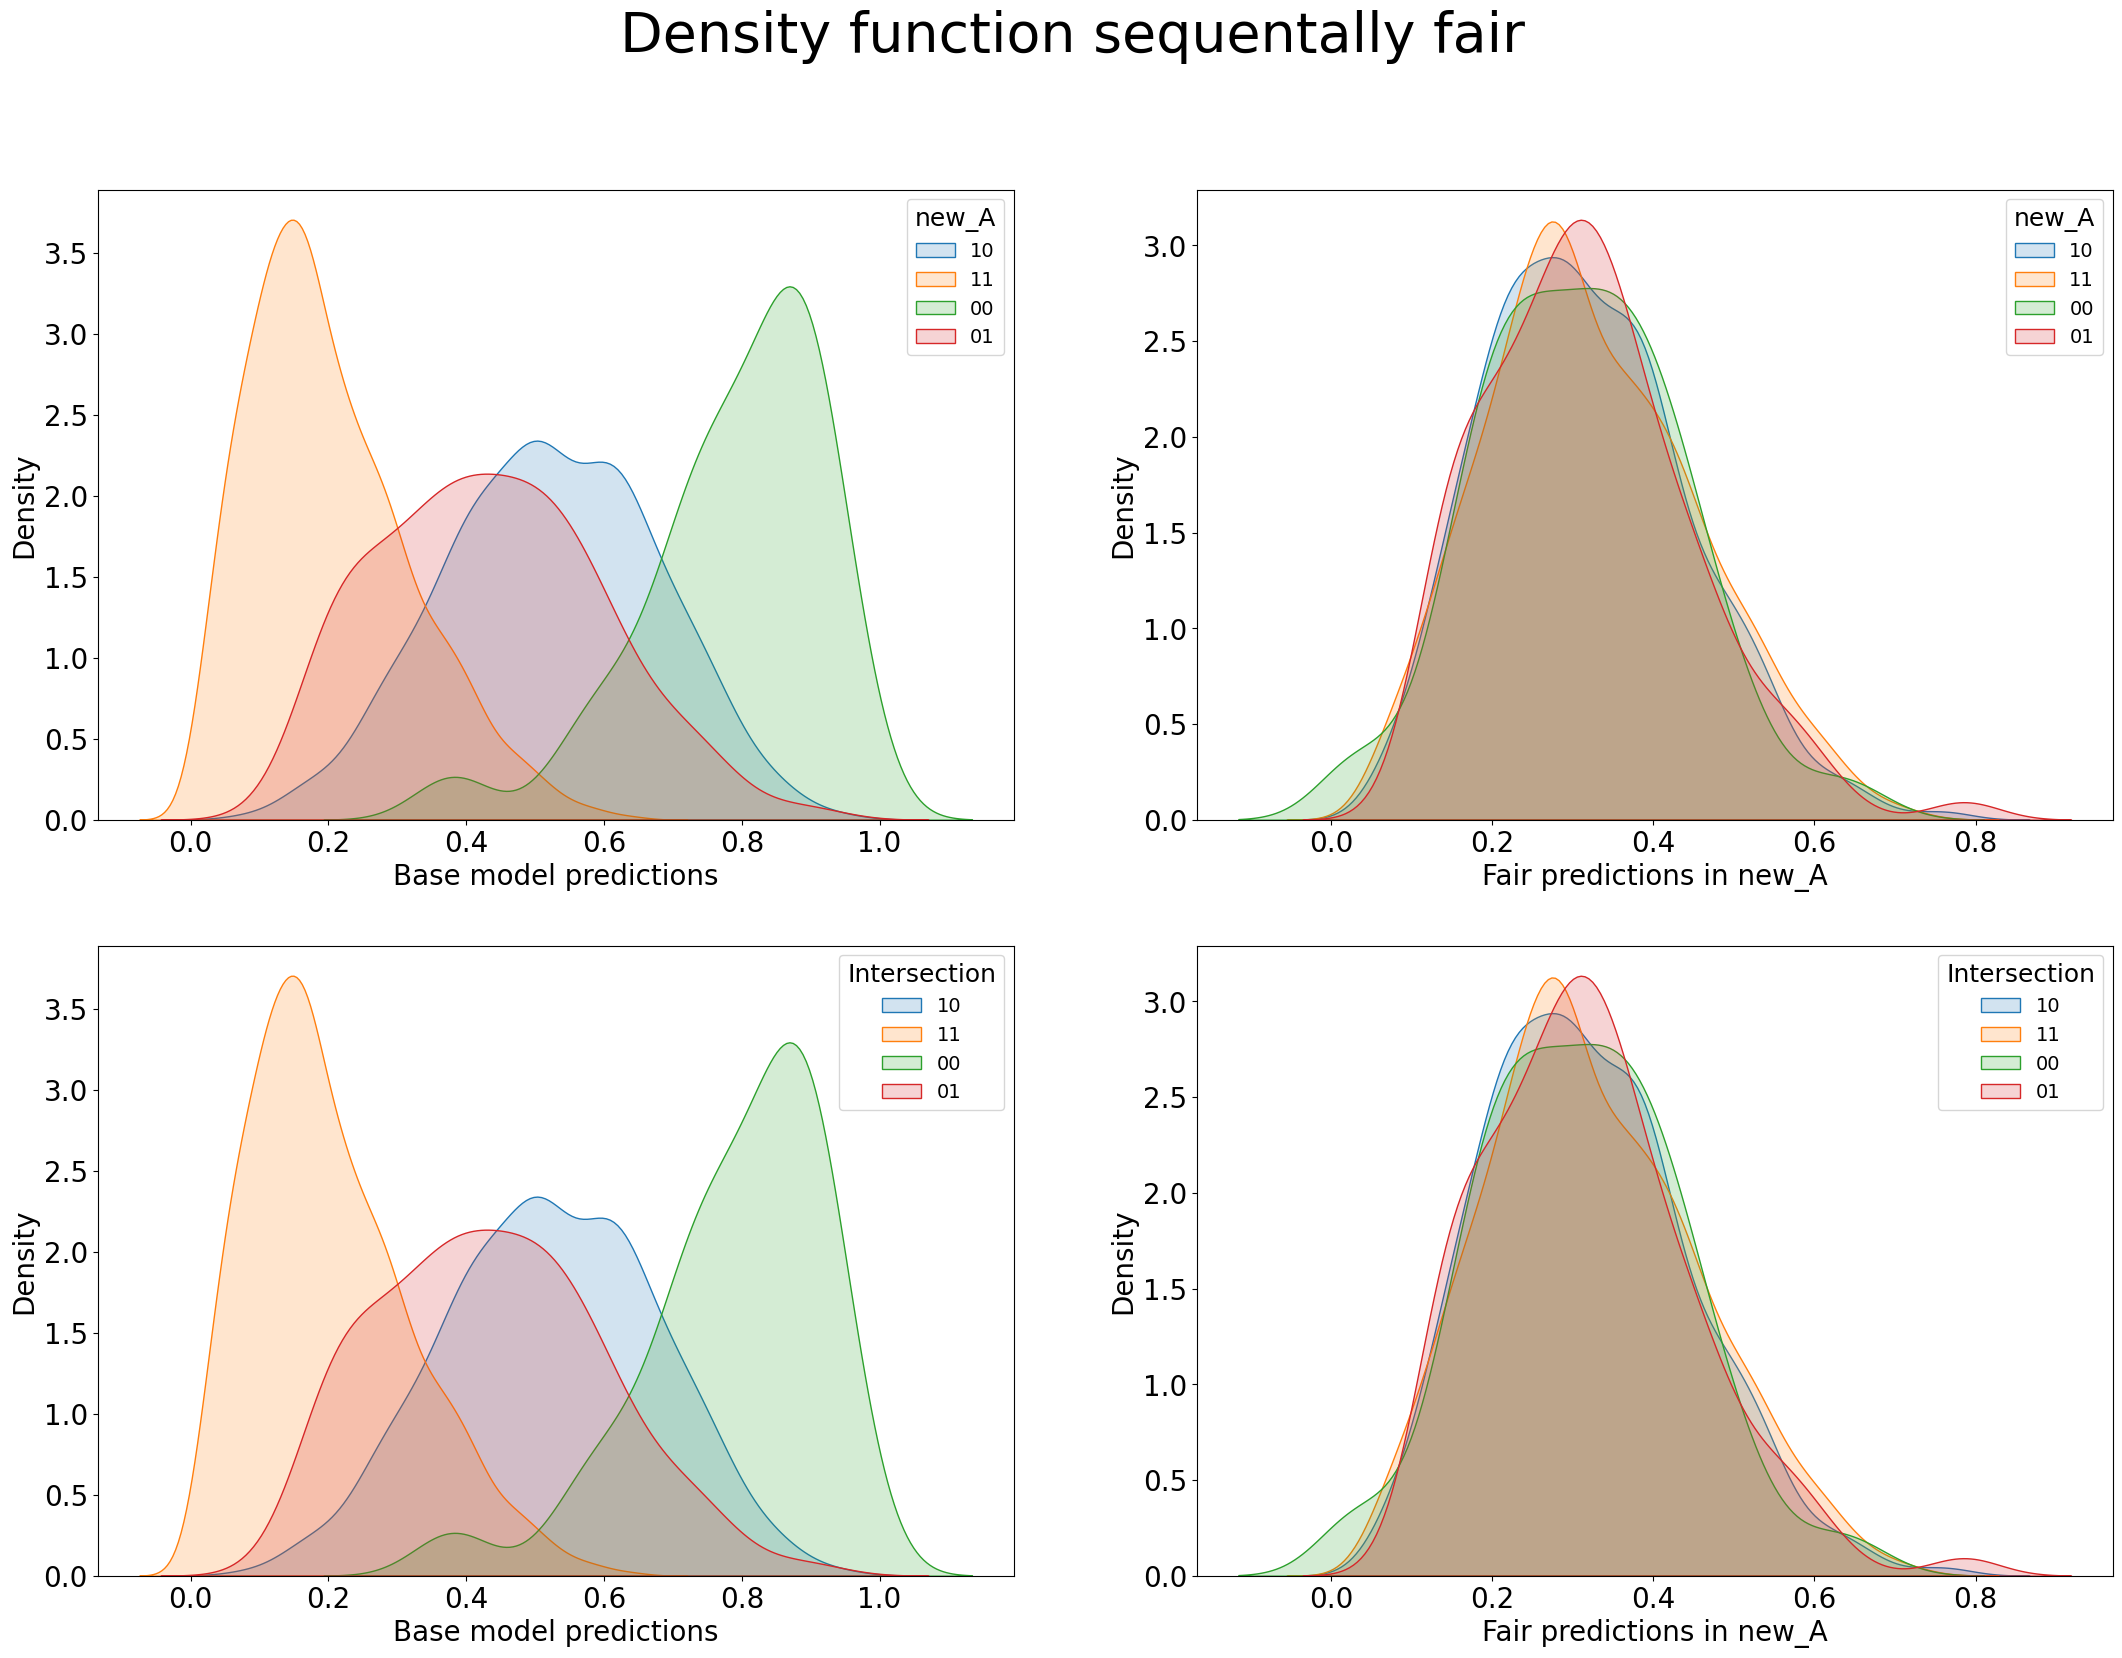

In [20]:
fair_density_plot(X_ssa_calib, X_ssa_test, scores_calib, scores_test)

## Sequential Fairness: A1 then A2

In [21]:
msa1_wst = MultiWasserstein()
msa1_wst.fit(scores_calib, X_calib)
fair_scores_msa1 = msa1_wst.transform(scores_test, X_test)
print("y_fair :", fair_scores_msa1)

y_fair : [0.25273225 0.30003663 0.22074898 ... 0.17615399 0.30450557 0.20801407]


In [22]:
print(f"Unfairness before mitigation: {unfairness(scores_test, X_test):.2f}")
print(f"Unfairness after mitigating biases from origin and sex: {unfairness(fair_scores_msa1, X_test):.2f}")

Unfairness before mitigation: 0.60
Unfairness after mitigating biases from origin and sex: 0.07


In [23]:
# Sequential fairness dictionnary
y_seq_fair = msa1_wst.y_fair
print("y_sequentially_fair :", y_seq_fair)

y_sequentially_fair : {'Base model': array([0.45681865, 0.51467691, 0.10754985, ..., 0.07696188, 0.5202824 ,
       0.38938987]), 'A1': array([0.48325179, 0.54078014, 0.12725044, ..., 0.09379626, 0.54608035,
       0.41853748]), 'A2': array([0.25273225, 0.30003663, 0.22074898, ..., 0.17615399, 0.30450557,
       0.20801407])}


In [24]:
# Calculate sequential unfairness
print(f"Unfairness before mitigation: {unfairness(y_seq_fair['Base model'], X_test):.2f}")
print(f"Unfairness after mitigating biases from A1: {unfairness(y_seq_fair['A1'], X_test):.2f}")
print(f"Unfairness after mitigating biases from A1 and A2: {unfairness(y_seq_fair['A2'], X_test):.2f}")

Unfairness before mitigation: 0.60
Unfairness after mitigating biases from A1: 0.34
Unfairness after mitigating biases from A1 and A2: 0.07


In [25]:
# Calculate unfairness given one specific attribute
y_A1 = y_seq_fair["A1"]
y_A1_A2 = y_seq_fair["A2"]
X_test_A1 = X_test[["A1"]]
X_test_A2 = X_test[["A2"]]
print(f"Unfairness regarding A1 Base model: {unfairness(scores_test, X_test_A1):.2f}")
print(f"Unfairness regarding A2 Base model: {unfairness(scores_test, X_test_A2):.2f}")
print(f"Unfairness regarding A1 Mitigation A1: {unfairness(y_A1, X_test_A1):.2f}")
print(f"Unfairness regarding A2 Mitigation A1: {unfairness(y_A1, X_test_A2):.2f}")
print(f"Unfairness regarding A1 Mitigation A2: {unfairness(y_A1_A2, X_test_A1):.2f}")
print(f"Unfairness regarding A2 Mitigation A2: {unfairness(y_A1_A2, X_test_A2):.2f}")

Unfairness regarding A1 Base model: 0.31
Unfairness regarding A2 Base model: 0.29
Unfairness regarding A1 Mitigation A1: 0.05
Unfairness regarding A2 Mitigation A1: 0.29
Unfairness regarding A1 Mitigation A2: 0.04
Unfairness regarding A2 Mitigation A2: 0.03


array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>]],
      dtype=object)

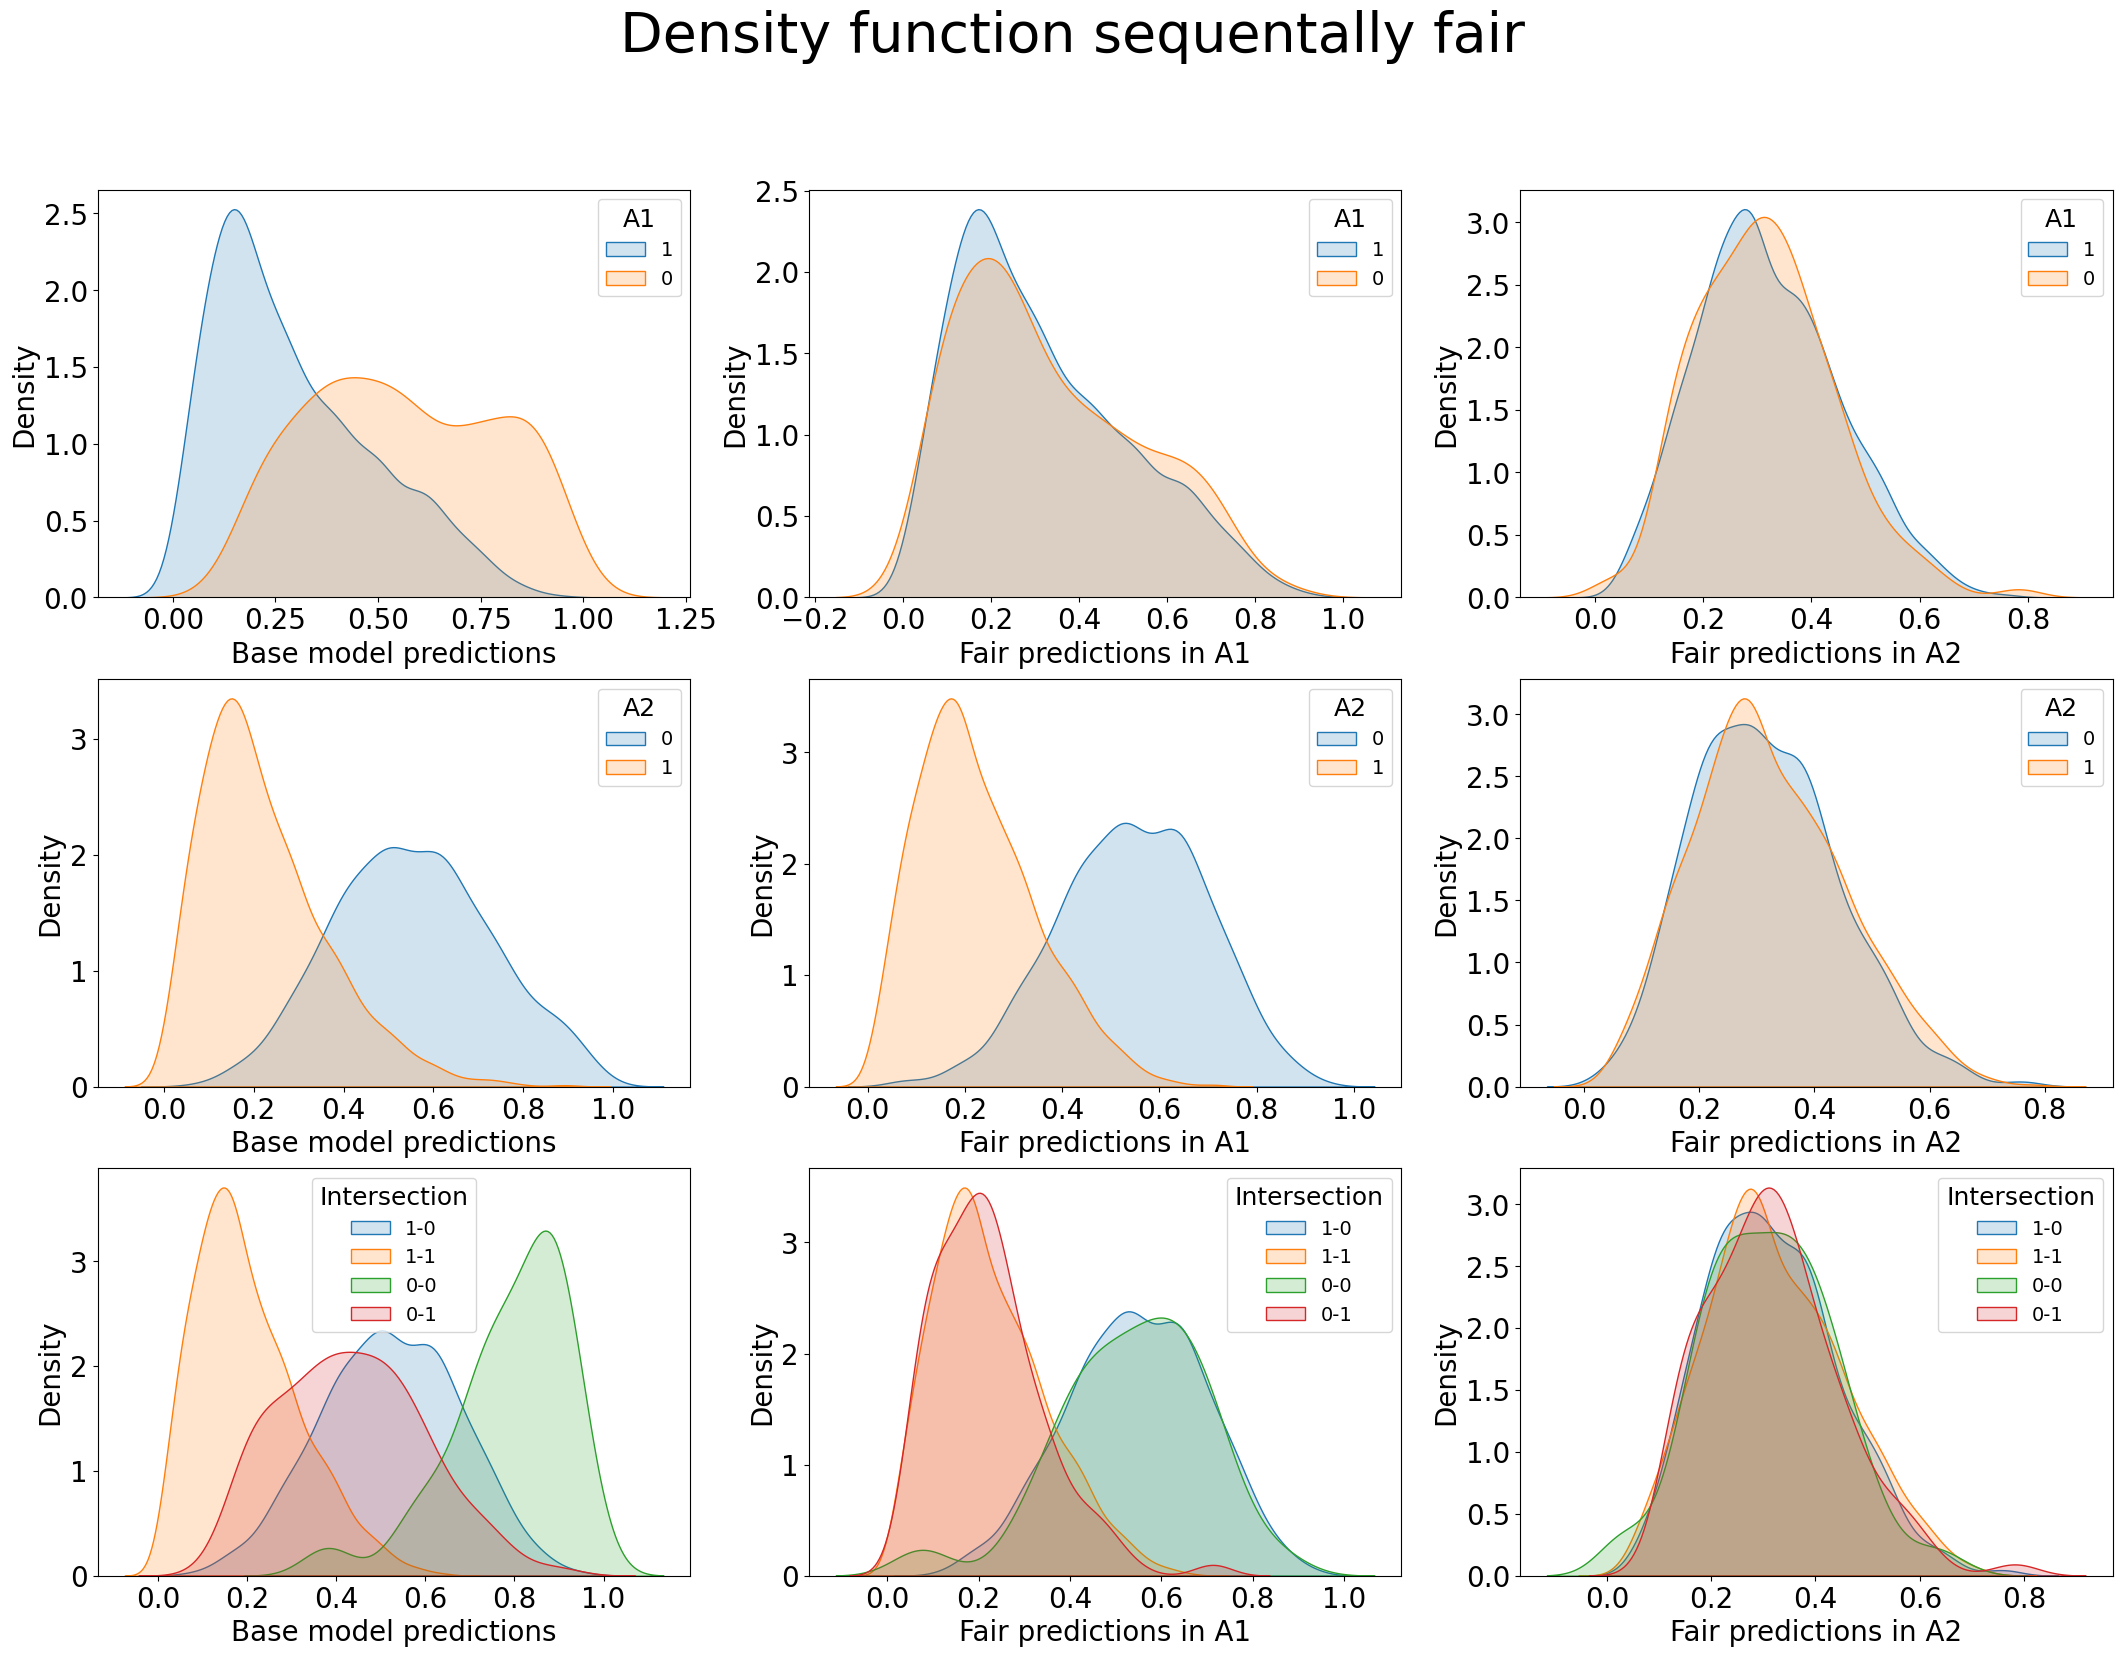

In [26]:
fair_density_plot(X_calib, X_test, scores_calib, scores_test)

array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in new_A', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in new_A', ylabel='Density'>]],
      dtype=object)

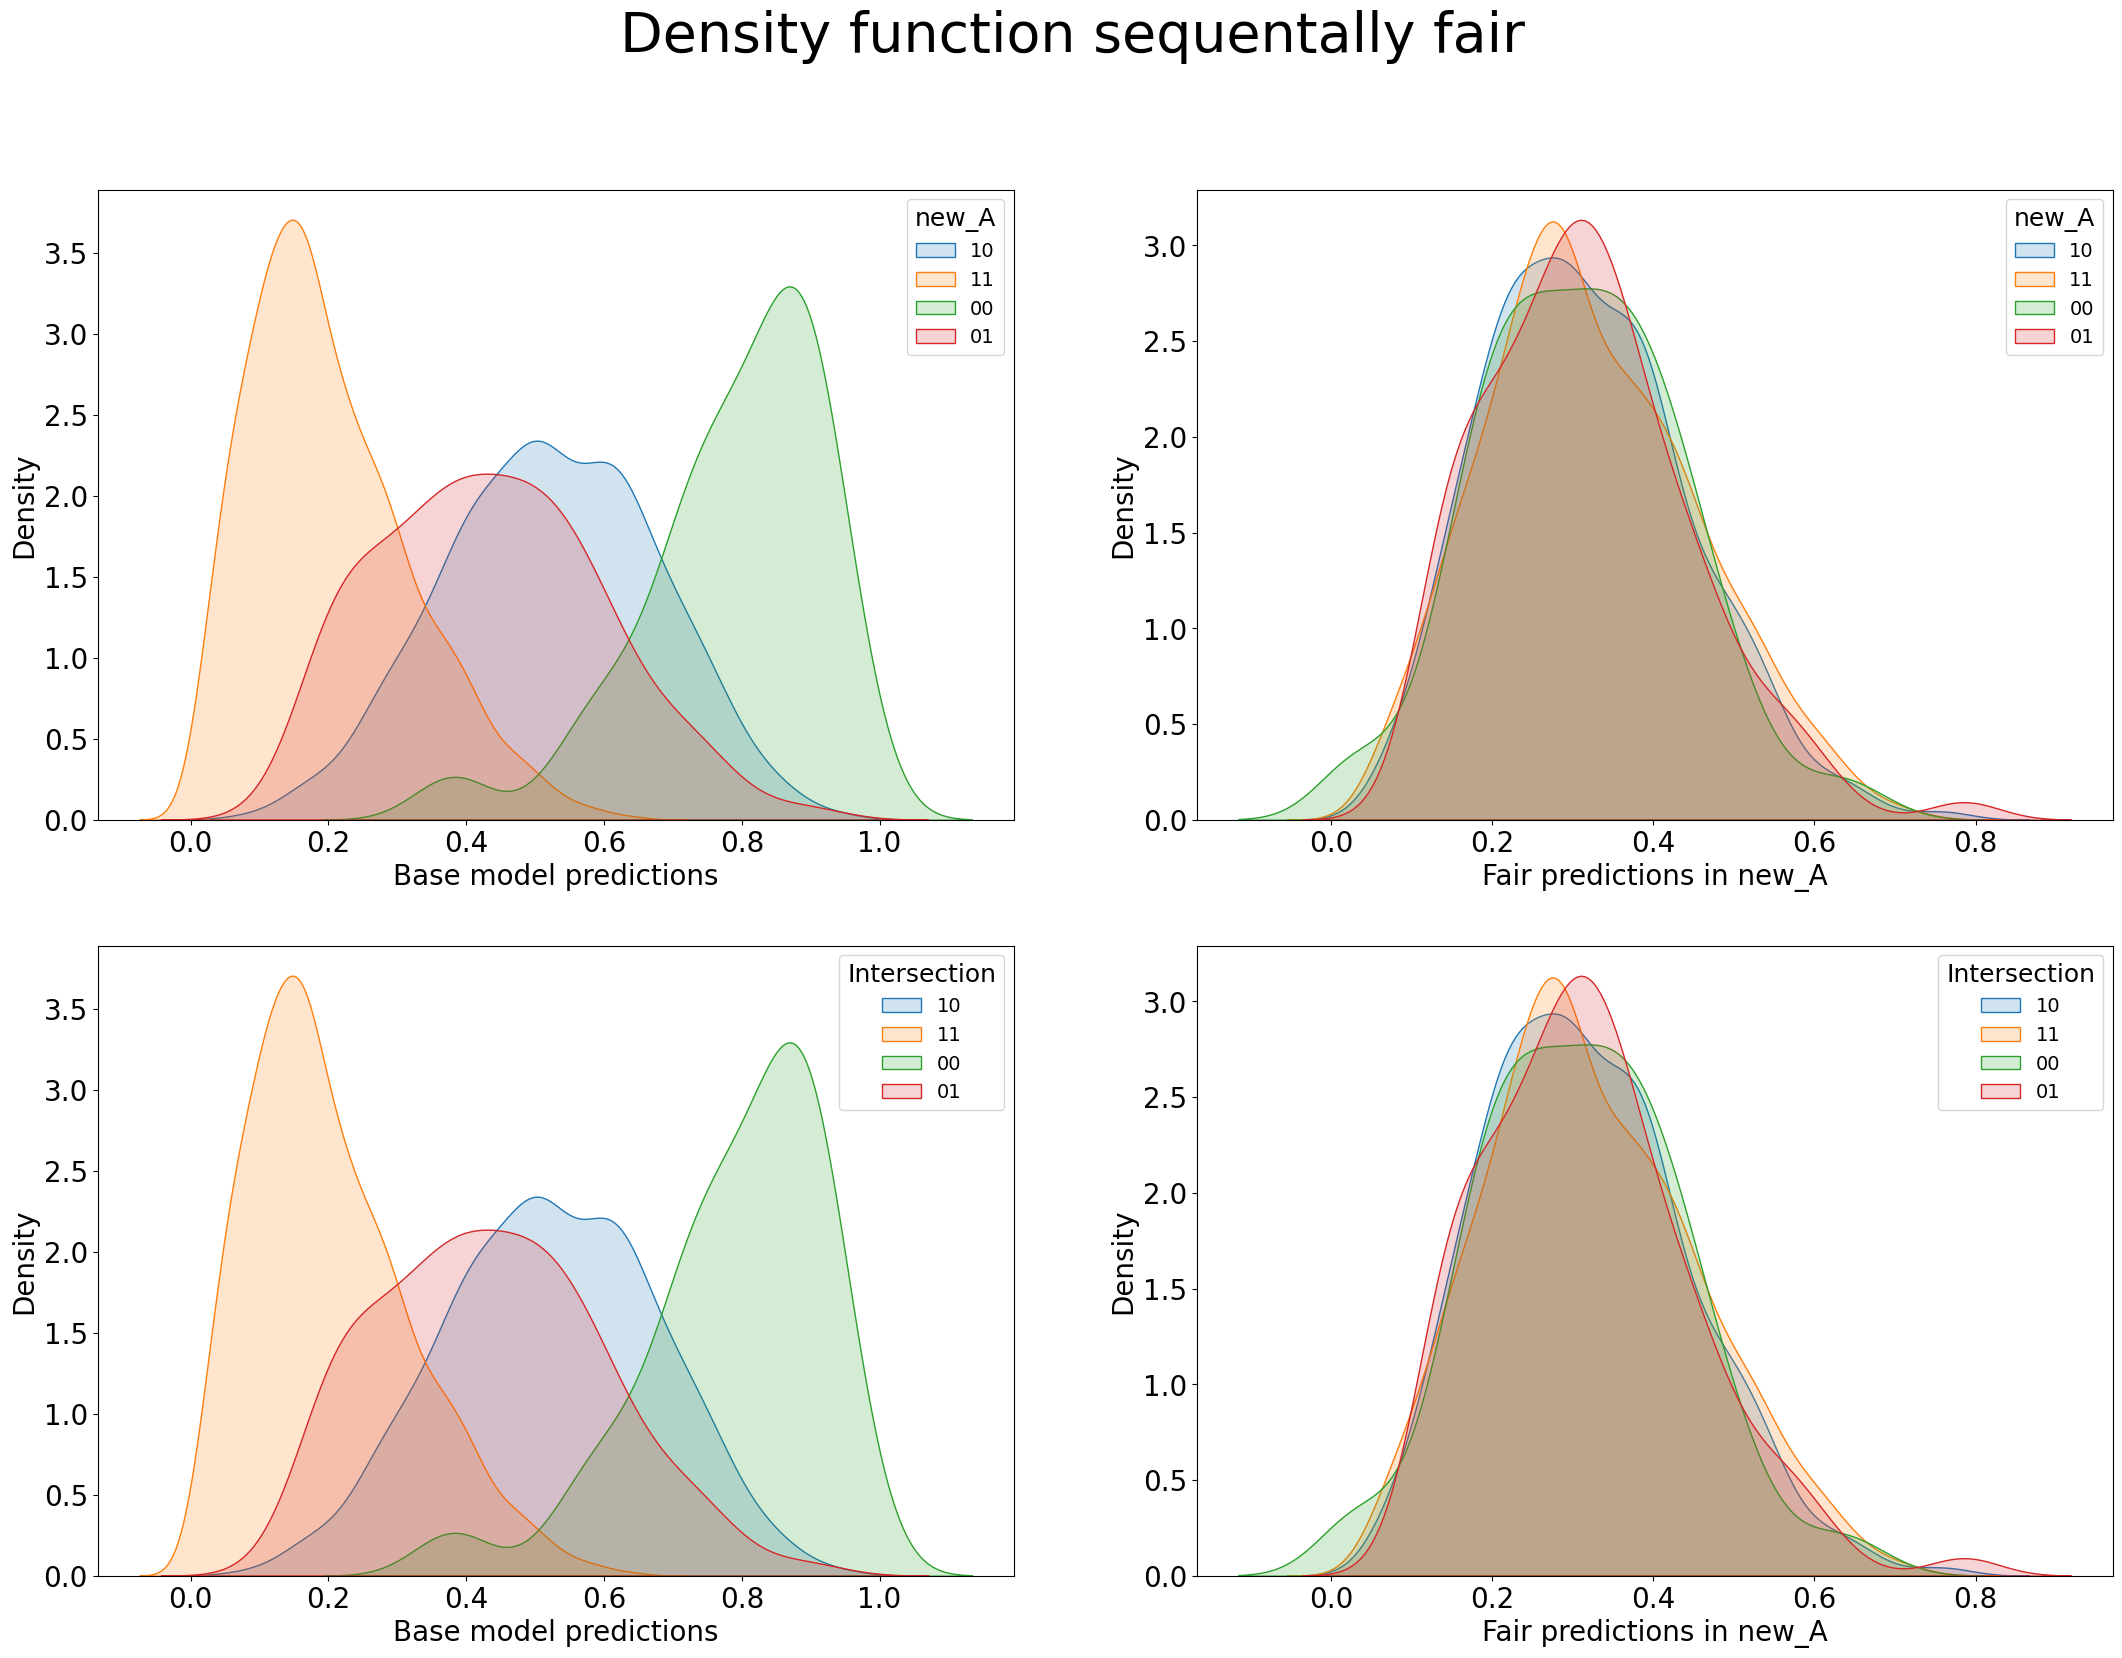

In [27]:
fair_density_plot(X_ssa_calib, X_ssa_test, scores_calib, scores_test)

## Sequential Fairness: A2 then A1

In [28]:
X2 = pd.DataFrame({
    'A2': A2,
    'A1': A1
})

In [29]:
# Split the data into training and testing sets
X2_calib, X2_test, scores_calib, scores_test = train_test_split(X2, scores, test_size=0.3, random_state=42)

# Display the shapes of the resulting sets to confirm the split
print("Training DataFrame shape:", X2_calib.shape)
print("Testing DataFrame shape:", X2_test.shape)
print("Training x shape:", scores_calib.shape)
print("Testing x shape:", scores_test.shape)

Training DataFrame shape: (7000, 2)
Testing DataFrame shape: (3000, 2)
Training x shape: (7000,)
Testing x shape: (3000,)


In [30]:
msa2_wst = MultiWasserstein()
msa2_wst.fit(scores_calib, X2_calib)
fair_scores_msa2 = msa2_wst.transform(scores_test, X2_test)
print("y_fair :", fair_scores_msa2)

y_fair : [0.25283785 0.30001011 0.22082301 ... 0.17602163 0.30463251 0.20822929]


In [31]:
print(f"Unfairness before mitigation: {unfairness(scores_test, X2_test):.2f}")
print(f"Unfairness after mitigating biases from origin and sex: {unfairness(fair_scores_msa2, X2_test):.2f}")

Unfairness before mitigation: 0.60
Unfairness after mitigating biases from origin and sex: 0.07


In [32]:
# Sequential fairness dictionnary
y_seq_fair2 = msa2_wst.y_fair
print("y_sequentially_fair :", y_seq_fair2)

y_sequentially_fair : {'Base model': array([0.45681865, 0.51467691, 0.10754985, ..., 0.07696188, 0.5202824 ,
       0.38938987]), 'A2': array([0.23043071, 0.27673618, 0.1995778 , ..., 0.15778   , 0.28087728,
       0.1873427 ]), 'A1': array([0.25283785, 0.30001011, 0.22082301, ..., 0.17602163, 0.30463251,
       0.20822929])}


In [33]:
# Calculate sequential unfairness
print(f"Unfairness before mitigation: {unfairness(y_seq_fair2['Base model'], X2_test):.2f}")
print(f"Unfairness after mitigating biases from A2: {unfairness(y_seq_fair2['A2'], X2_test):.2f}")
print(f"Unfairness after mitigating biases from A2 and A1: {unfairness(y_seq_fair2['A1'], X2_test):.2f}")

Unfairness before mitigation: 0.60
Unfairness after mitigating biases from A2: 0.27
Unfairness after mitigating biases from A2 and A1: 0.07


In [34]:
# Calculate unfairness given one specific attribute
y_A2 = y_seq_fair2["A2"]
y_A2_A1 = y_seq_fair2["A1"]
X2_test_A2 = X2_test[["A2"]]
X2_test_A1 = X2_test[["A1"]]
print(f"Unfairness regarding A1 Base model: {unfairness(scores_test, X2_test_A1):.2f}")
print(f"Unfairness regarding A2 Base model: {unfairness(scores_test, X2_test_A2):.2f}")
print(f"Unfairness regarding A1 Mitigation A2: {unfairness(y_A2, X2_test_A1):.2f}")
print(f"Unfairness regarding A2 Mitigation A2: {unfairness(y_A2, X2_test_A2):.2f}")
print(f"Unfairness regarding A1 Mitigation A1: {unfairness(y_A2_A1, X2_test_A1):.2f}")
print(f"Unfairness regarding A2 Mitigation A1: {unfairness(y_A2_A1, X2_test_A2):.2f}")

Unfairness regarding A1 Base model: 0.31
Unfairness regarding A2 Base model: 0.29
Unfairness regarding A1 Mitigation A2: 0.24
Unfairness regarding A2 Mitigation A2: 0.02
Unfairness regarding A1 Mitigation A1: 0.04
Unfairness regarding A2 Mitigation A1: 0.03


array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>]],
      dtype=object)

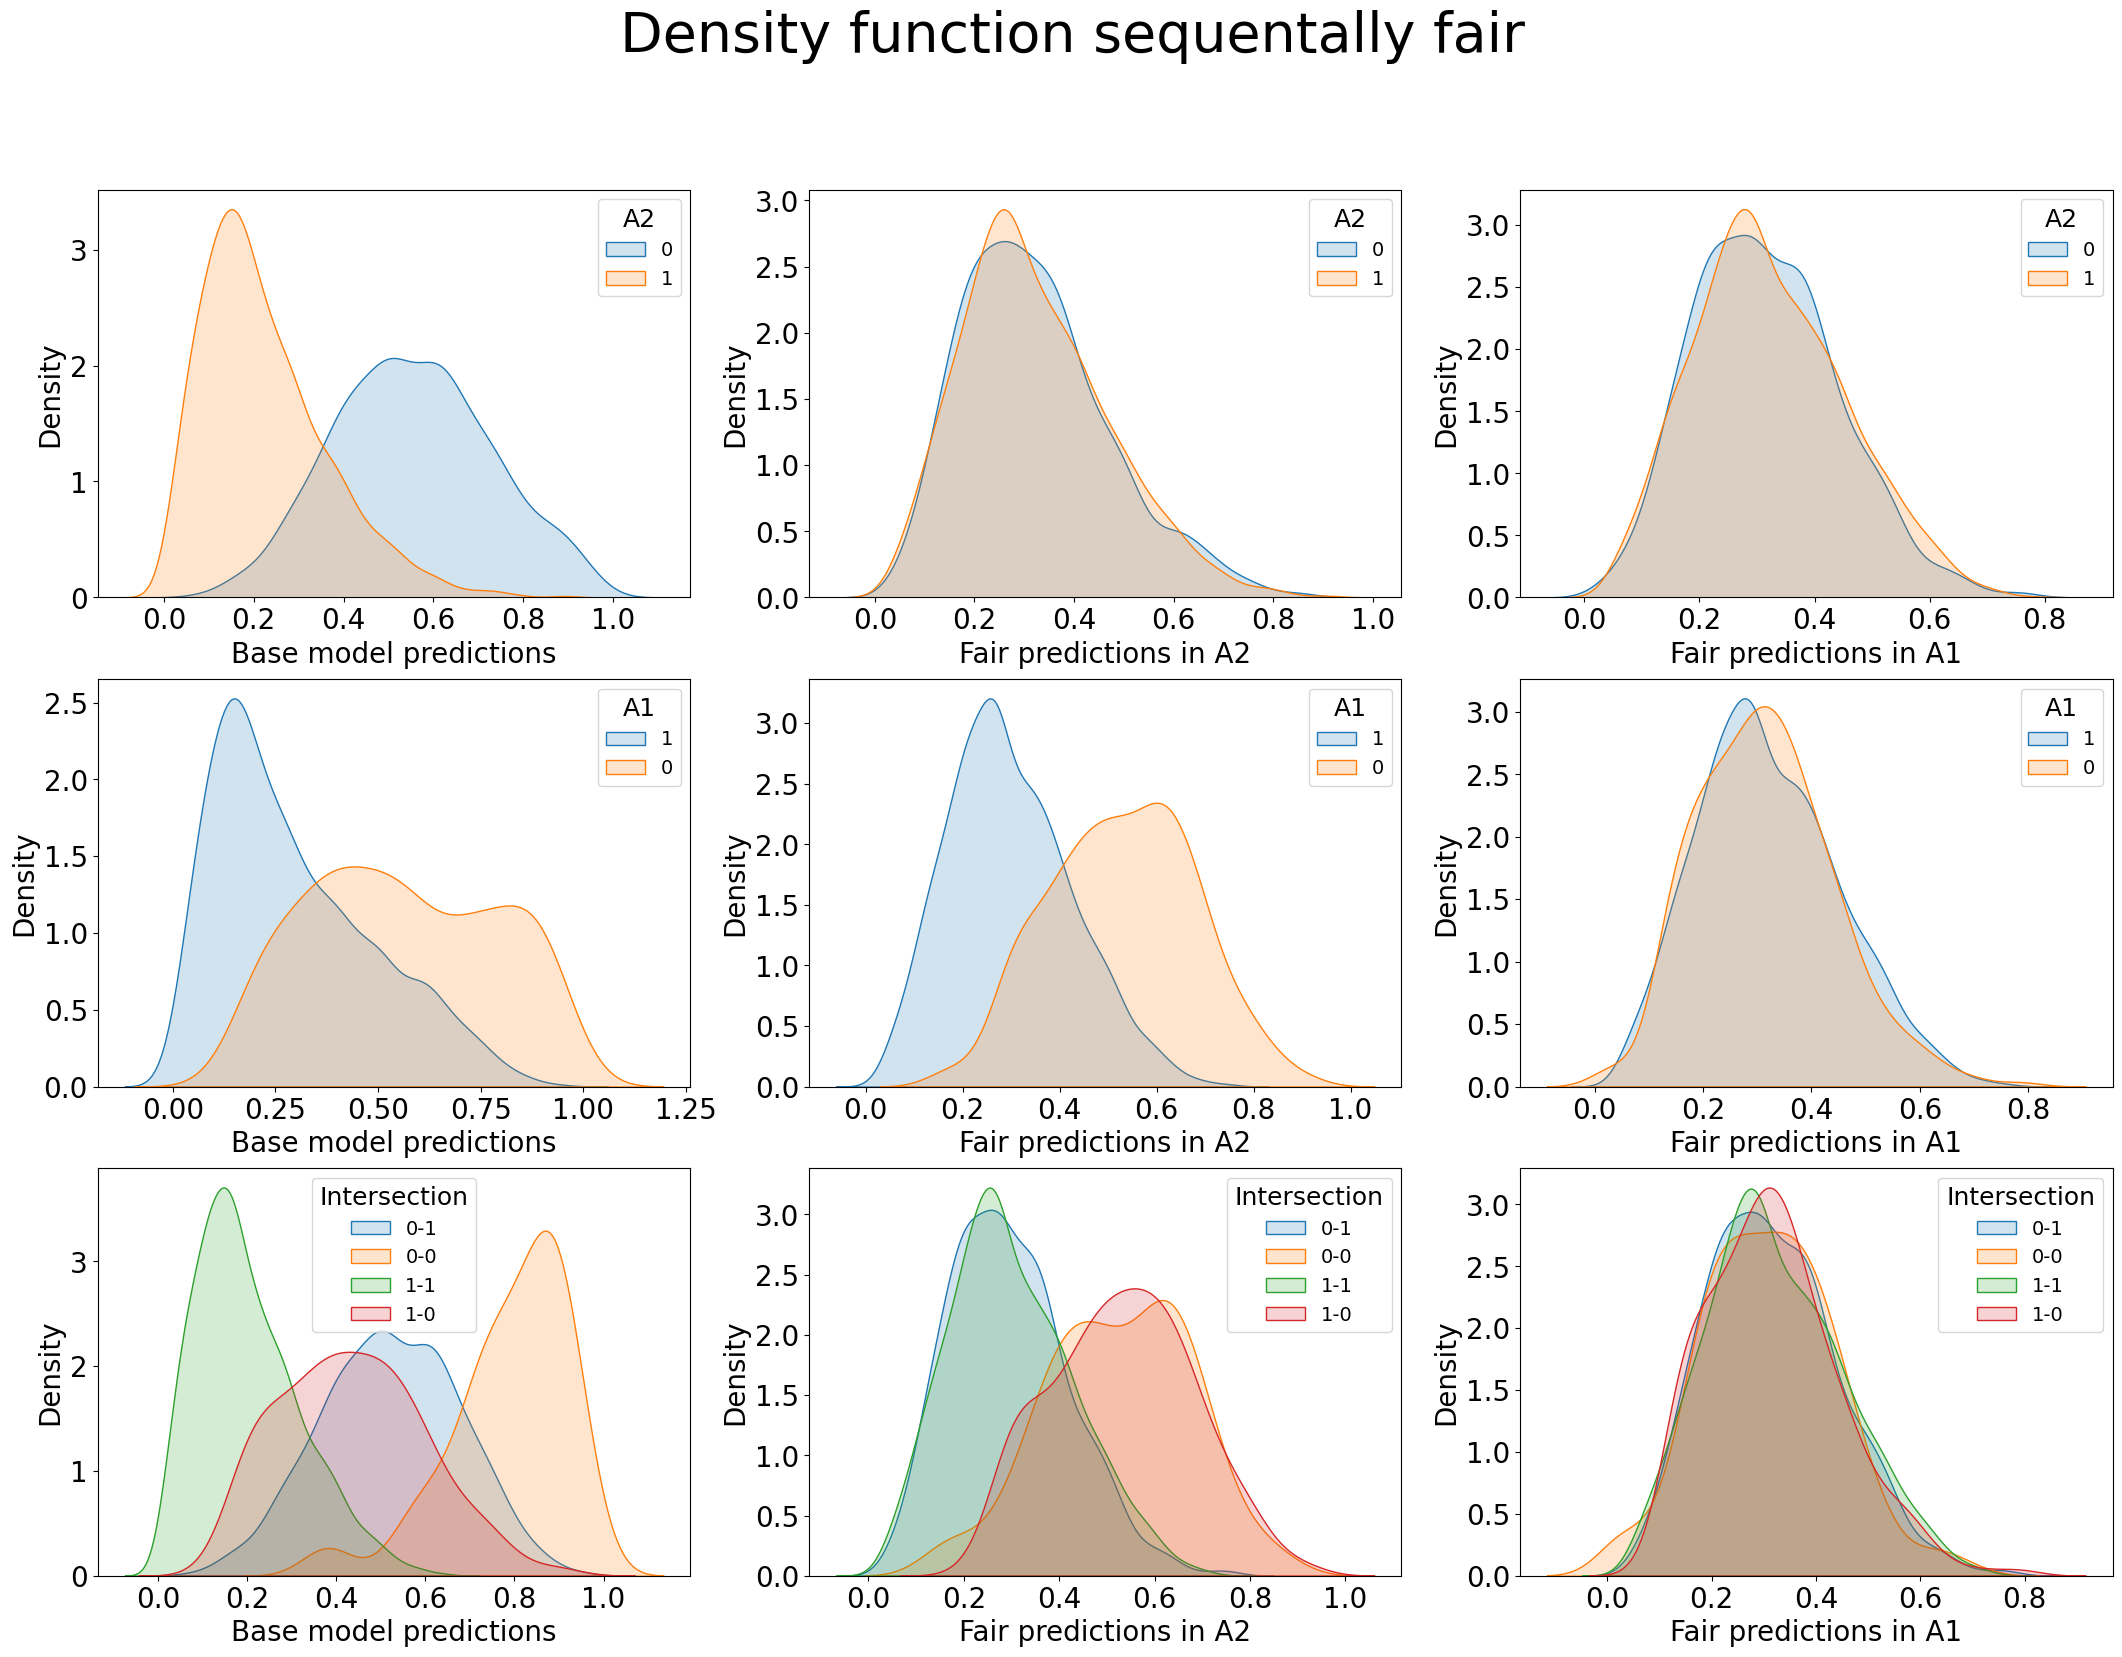

In [35]:
fair_density_plot(X2_calib, X2_test, scores_calib, scores_test)

In [36]:
from equipy.graphs import fair_waterfall_plot

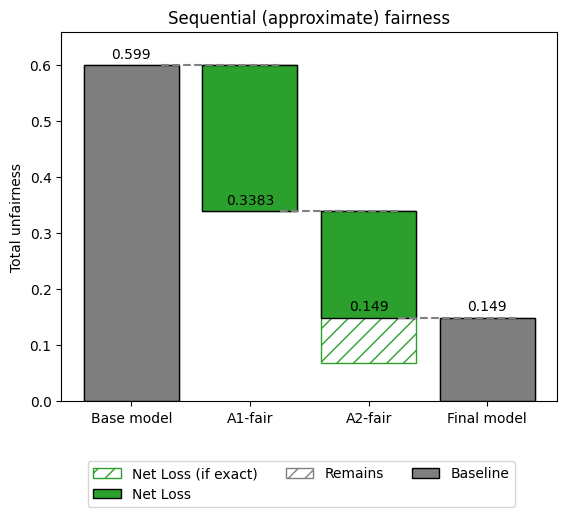

<Axes: title={'center': 'Sequential (approximate) fairness'}, ylabel='Total unfairness'>

In [37]:
fair_waterfall_plot(X_calib, X_test, scores_calib, scores_test, epsilon=[0,0.4])

In [38]:
from equipy.graphs import fair_arrow_plot, fair_multiple_arrow_plot

<Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>

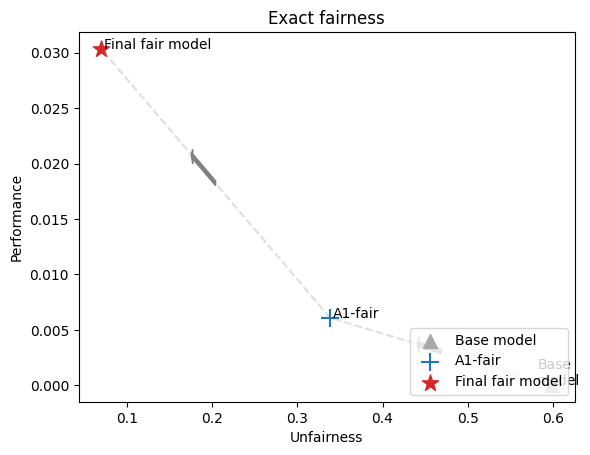

In [39]:
fair_arrow_plot(X_calib, X_test, scores_calib, scores_test, noisy_scores_test)

<Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>

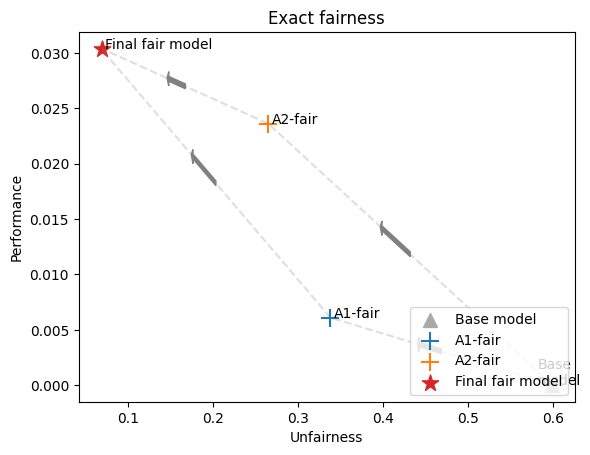

In [40]:
fair_multiple_arrow_plot(X_calib, X_test, scores_calib, scores_test, noisy_scores_test)